![](https://static.posters.cz/image/750/poster/il-trono-di-spade-game-of-thrones-logo-i21034.jpg)

(983, 68)
86 unique characters
E
a
s
y
,
"Easy, boy.\nYou need to drink, child.\nWelcome, Lord Stark.\nThe little lord's been dreaming again.\nDoes"
' Ser Hugh have any family in the capital?\nYour pardon, Your Grace.\n"Summoned to court to answer for t'
"he crimes\nYah! Left high, left low.\nYou've seen better days, my lord.\nLook at me. Look at me!\nWell st"
"ruck.\nGotta be ready before nightfall.\nOut, all of you.\nIt's got to be the Mountain. He's the biggest"
".\n- You swear it? - By the mother.\nI've taken your castle.\nA cripple?\n- Riders approaching! - Open th"
Input data:  "Easy, boy.\nYou need to drink, child.\nWelcome, Lord Stark.\nThe little lord's been dreaming again.\nDoe"
Target data: "asy, boy.\nYou need to drink, child.\nWelcome, Lord Stark.\nThe little lord's been dreaming again.\nDoes"
Step    0
  input: 32 ('E')
  expected output: 56 ('a')
Step    1
  input: 56 ('a')
  expected output: 74 ('s')
Step    2
  input: 74 ('s')
  expected output: 80 ('y')
Step    3
  in

ValueError: in user code:

    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:806 train_function  *
        return step_function(self, iterator)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:789 run_step  **
        outputs = model.train_step(data)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:747 train_step
        y_pred = self(x, training=True)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:985 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:372 call
        return super(Sequential, self).call(inputs, training=training, mask=mask)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/functional.py:386 call
        inputs, training=training, mask=mask)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/functional.py:508 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/layers/recurrent.py:659 __call__
        return super(RNN, self).__call__(inputs, **kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:976 __call__
        self.name)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/input_spec.py:227 assert_input_compatibility
        ', found shape=' + str(shape))

    ValueError: Input 0 is incompatible with layer gru_1: expected shape=(1, None, 256), found shape=[64, 100, 256]


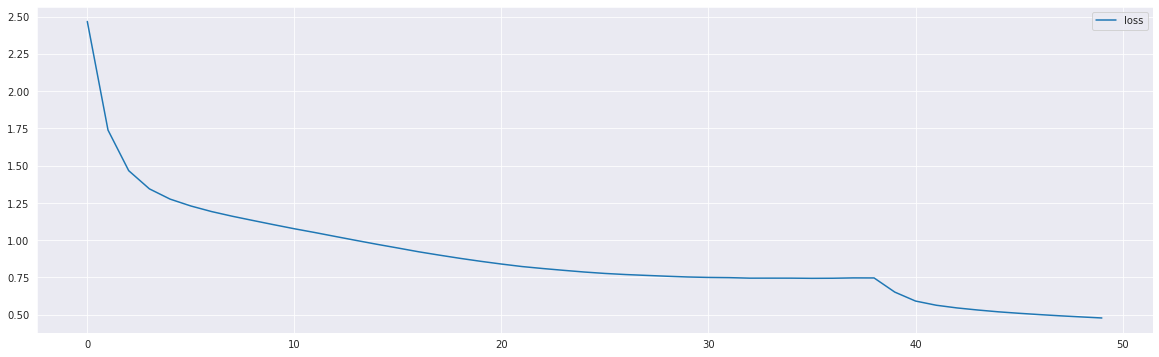

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from pylab import rcParams

rcParams['figure.figsize'] = 20, 6
rcParams['axes.grid'] = True

df = [pd.read_json(f'../input/game-of-thrones-srt/season{i+1}.json') for i in range(7)]
df = pd.concat(df, axis=1)
print(df.shape)
df.head()

df = pd.DataFrame(df.values.reshape(-1, 1), columns=['Script']).dropna().reset_index(drop=True)
df.head()

import re
cleanr = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')

def cleanhtml(raw_html):
  cleantext = re.sub(cleanr, '', raw_html)
  return cleantext

df['Script'] = df['Script'].apply(cleanhtml)

text = '\n'.join(df['Script'].values)
vocab = sorted(set(text))
print('{} unique characters'.format(len(vocab)))

char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

text_as_int = np.array([char2idx[c] for c in text])

import tensorflow as tf


seq_length = 100
examples_per_epoch = len(text)//(seq_length+1)

char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

for i in char_dataset.take(5):
    print(idx2char[i.numpy()])
    
    
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)

for item in sequences.take(5):
    print(repr(''.join(idx2char[item.numpy()])))
    
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)

for input_example, target_example in  dataset.take(1):
    print('Input data: ', repr(''.join(idx2char[input_example.numpy()])))
    print('Target data:', repr(''.join(idx2char[target_example.numpy()])))
    
for i, (input_idx, target_idx) in enumerate(zip(input_example[:5], target_example[:5])):
    print("Step {:4d}".format(i))
    print("  input: {} ({:s})".format(input_idx, repr(idx2char[input_idx])))
    print("  expected output: {} ({:s})".format(target_idx, repr(idx2char[target_idx])))
    
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

dataset

# Length of the vocabulary in chars
vocab_size = len(vocab)

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = ['G1024']


from keras.models import Sequential, load_model
from keras.layers import Embedding, SimpleRNN, LSTM, GRU, Dense 
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.utils import plot_model

es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=10)
filepath = "model.h5"
ckpt = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min', save_weights_only=True)
rlp = ReduceLROnPlateau(monitor='loss', patience=3, verbose=1)

def build_model(vocab_size, embedding_dim, rnn_units, batch_size=None):
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, batch_input_shape=[batch_size, None]))
    for rnn_unit in rnn_units:
        layer_type = rnn_unit[0]
        num_cells = int(rnn_unit[1:])
        if layer_type == 'G':
            model.add(GRU(
                num_cells, return_sequences=True, stateful=True, recurrent_initializer='glorot_uniform'
            ))
        elif layer_type == 'L':
            model.add(LSTM(
                num_cells, return_sequences=True, stateful=True, recurrent_initializer='glorot_uniform'
            ))
        else:
            model.add(SimpleRNN(
                num_cells, return_sequences=True, stateful=True, recurrent_initializer='glorot_uniform'
            ))

    model.add(Dense(vocab_size))
    return model


model = build_model(
    vocab_size=len(vocab),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units,
    batch_size=64
)


model.summary()
plot_model(model, show_shapes=True)

for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()

sampled_indices

print("Input: \n", repr("".join(idx2char[input_example_batch[0]])))
print()
print("Next Char Predictions: \n", repr("".join(idx2char[sampled_indices ])))


def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

def accuracy(labels, logits):
    predicted_ids = tf.argmax(logits, axis=-1)
    predicted_ids = tf.cast(predicted_ids, tf.int32)  # Cast logits to int32
    labels = tf.cast(labels, tf.int32)  # Add this line to cast labels to int32
    correct_predictions = tf.equal(predicted_ids, labels)
    return tf.reduce_mean(tf.cast(correct_predictions, tf.float32))



example_batch_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("scalar_loss:      ", example_batch_loss.numpy().mean())

# Compile the model with loss and accuracy metrics
model.compile(optimizer='adam', loss=loss, metrics=[accuracy])


EPOCHS = 50
history = model.fit(dataset, epochs=EPOCHS, callbacks=[es, ckpt, rlp])
pd.DataFrame(history.history)[['loss']].plot();

learning_rates = [0.001, 0.01, 0.1]  # Example learning rates to experiment with

histories = []

for lr in learning_rates:
    # Rebuild the model
    model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)
    model.compile(optimizer=tf.keras.optimizers.Adam(lr), loss=loss, metrics=[accuracy])
    
    # Train the model
    history = model.fit(dataset, epochs=EPOCHS, callbacks=[es, ckpt, rlp], verbose=0)
    
    histories.append(history)

# Plot the loss and accuracy curves for each learning rate
plt.figure(figsize=(12, 8))
for i, lr in enumerate(learning_rates):
    plt.subplot(2, 1, 1)
    plt.plot(histories[i].history['loss'], label='lr={}'.format(lr))
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(histories[i].history['accuracy'], label='lr={}'.format(lr))
    plt.title('Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

plt.tight_layout()
plt.show()

model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)
model.load_weights(filepath)
model.build(tf.TensorShape([1, None]))
model.summary()


def generate_text(model, start_string):
    # Evaluation step (generating text using the learned model)

    # Number of characters to generate
    num_generate = 1000

    # Converting our start string to numbers (vectorizing)
    input_eval = [char2idx[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)

    # Empty string to store our results
    text_generated = []

    # Low temperature results in more predictable text.
    # Higher temperature results in more surprising text.
    # Experiment to find the best setting.
    temperature = 1.0

    # Here batch size == 1
    model.reset_states()
    for i in range(num_generate):
        predictions = model(input_eval)
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        # using a categorical distribution to predict the character returned by the model
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

        # Pass the predicted character as the next input to the model
        # along with the previous hidden state
        input_eval = tf.expand_dims([predicted_id], 0)

        text_generated.append(idx2char[predicted_id])

    return (start_string + ''.join(text_generated))

print(generate_text(model, start_string="Hells"))
